In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder ,MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score,recall_score,precision_score
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import l1_min_c
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from statistics import stdev
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/mujahidashraf/data/refs/heads/main/heart_disease_data.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48,1,0,130,256,1,0,150,1,0.0,2,2,3,0
1,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
2,44,0,2,118,242,0,1,149,0,0.3,1,1,2,1
3,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
4,56,1,3,120,193,0,0,162,0,1.9,1,0,3,1


In [ ]:
X=df.drop(columns=['target'])
y=df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.3, random_state = 10)

In [ ]:
pipeline_gnb = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB())
])

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500))
])

pipeline_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(criterion='gini',
        max_depth=3,
        min_samples_leaf=2,
        min_samples_split=2,
        random_state=42))
])

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, kernel='rbf', degree=3, gamma='scale', probability=True))  # Enable probability for soft voting
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Not necessary for RandomForest but included for consistency
    ('rf', RandomForestClassifier(random_state=42))
])

# Voting Classifier with all pipelines
Stacking_clf = StackingClassifier(estimators=[
    ('gnb', pipeline_gnb),
    ('knn', pipeline_knn),
    ('logreg', pipeline_logreg),
    ('tree', pipeline_tree),
    ('svm', pipeline_svm),
    ('rf', pipeline_rf)],
                                  final_estimator=pipeline_rf,
                                  cv=5

                          )

# Train the ensemble
Stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('gnb',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('gnb', GaussianNB())])),
                               ('knn',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier())])),
                               ('logreg',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(max_iter=500))])),
                               ('tree',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                (...
                                                 DecisionTreeClassifier(max_depth=3,
                                                                        min_samples_leaf=2,
                                                                        random_state=42))])),
                               ('svm',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svm',
                                                 SVC(C=1, probability=True))])),
                               ('rf',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('rf',
                                                 RandomForestClassifier(random_state=42))]))],
                   final_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                   ('rf',
                                                    RandomForestClassifier(random_state=42))]))

In [ ]:
for name, clf in Stacking_clf.named_estimators_.items():
  print(name, "=", clf.score(X_test, y_test))

gnb = 0.8571428571428571
knn = 0.8296703296703297
logreg = 0.8186813186813187
tree = 0.8296703296703297
svm = 0.9010989010989011
rf = 0.9560439560439561


In [ ]:
Stacking_clf.score(X_test, y_test)

0.9615384615384616

In [ ]:
y_pred = Stacking_clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Voting Classifier training Accuracy: {accuracy:.4f}")
y_pred = Stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier test Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

Voting Classifier training Accuracy: 0.9976
Voting Classifier test Accuracy: 0.9615
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        91
           1       0.96      0.97      0.96        91

    accuracy                           0.96       182
   macro avg       0.96      0.96      0.96       182
weighted avg       0.96      0.96      0.96       182



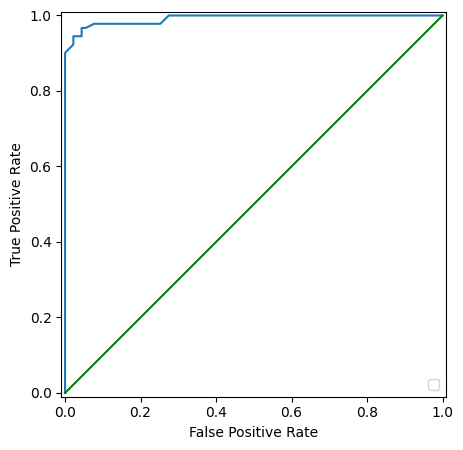

In [ ]:
y_proba = Stacking_clf.predict_proba(X_test)

def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
plot_auc_roc_curve(y_test, y_proba[:, 1])

In [ ]:
score = cross_val_score(Stacking_clf, X_train, y_train, cv=5, scoring='accuracy', error_score="raise")
SC_cv_score = score.mean()
SC_cv_stdev = stdev(score)
print('Cross Validation accuracy scores are: {}'.format(score))
print('Average Cross Validation accuracy score: ', SC_cv_score)
print('Cross Validation accuracy standard deviation: ', SC_cv_stdev)

Cross Validation accuracy scores are: [0.90588235 0.90588235 0.91764706 0.85882353 0.92857143]
Average Cross Validation accuracy score:  0.9033613445378151
Cross Validation accuracy standard deviation:  0.026626856332361133
